# Circular waveguide filter - Discussion

In [8]:
import os
import sys

dir = os.getcwd() + '/shared/examples/circular_waveguide_filter'
src = os.getcwd() + '/shared'
sys.path.append(dir)
sys.path.append(src)

%load_ext autoreload
%autoreload 2

In [23]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg

import fenics as fen
from circular_waveguide_filter import CircularWaveguideFilter

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

### Dimensions and properties

In [11]:
# Dimensions in meters
Lc = 0.04387  # Length of the cavities
Ls = 0.00150  # Length of the slots
Lr = 0.02000  # Length of rectangular input/output WR75-waveguide
Hr = 0.009525 # Height of rectangular input/output WR75-waveguide
Wr = 0.01905  # Width of rectangular input/output WR75-waveguide

Dx = Ls/2 + Lc + Ls + Lr  # |x|-coordinate of input/output boundary
Dy = Wr/2  # |y|-limit of input/output boundary
Dz = Hr/2  # |z|-limit of input/output boundary

In [14]:
class B_N(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(abs(x[0]), Dx) and x[1]>-Dy and x[1]<Dy and x[2]>-Dz and x[2]<Dz

class g_N_L(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        value[2] = 1.0 / (4e-7*np.pi) if fen.near(x[0], -Dx) else 0.0
    def value_shape(self):
        return (3,)

class g_N_R(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        value[2] = - 1.0 / (4e-7*np.pi) if fen.near(x[0], -Dx) else 0.0
    def value_shape(self):
        return (3,)

mesh = dir + '/model/DMCWF.xml'
CWF = CircularWaveguideFilter(mesh, B_N, g_N=g_N_L())
VS = VectorSpaceL2(CWF)

### Solution of problem

In [15]:
CWF.setup()

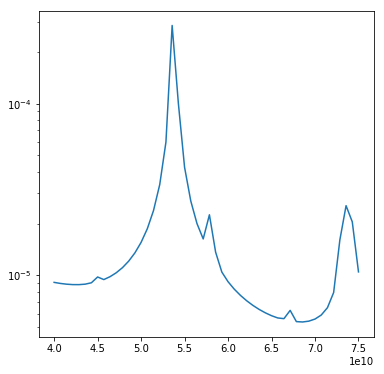

In [19]:
a = 4e+10
b = 7.5e+10
fig, ax = plt.subplots(figsize=(6, 6), sharex=True)
omegas = np.linspace(a, b, 50)
CWF.solve(omegas)
helpers.plot_solution_norms(ax, CWF, VS)

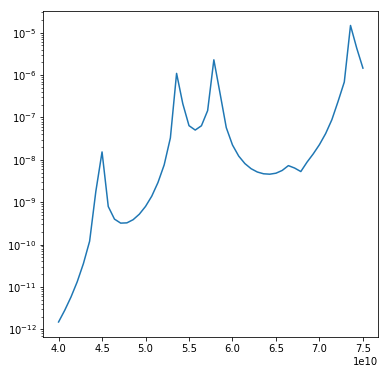

In [20]:
class trace(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], Dx) and x[1]>-Dy and x[1]<Dy and x[2]>-Dz and x[2]<Dz

VS = VectorSpaceL2(CWF, trace())
fig, ax = plt.subplots(figsize=(6, 6), sharex=True)
helpers.plot_solution_norms(ax, CWF, VS)

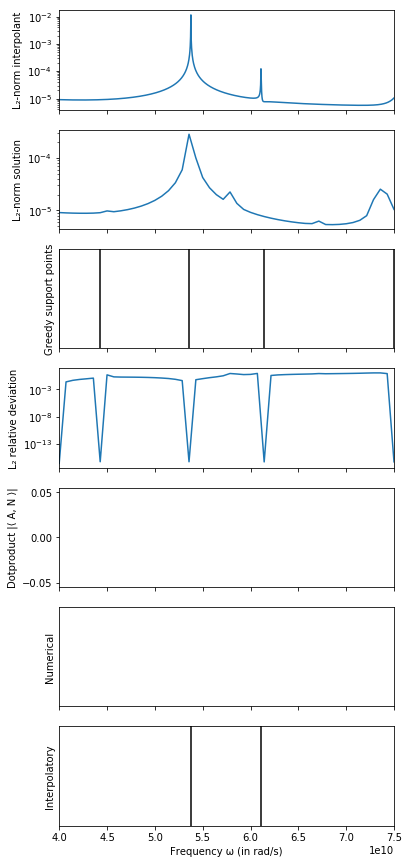

In [26]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

VS = VectorSpaceL2(CWF)
a = 4e+10
b = 7.5e+10
#omegas = np.linspace(a, b, 300)
#RC.solve(omegas)
MRI = MinimalRationalInterpolation(VS)
snapshots = CWF.get_solution(tonumpy=True, trace=VS.get_trace())
omegas = CWF.get_frequency()
MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-0)

ax[0].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[0], MRI, VS, a, b)

ax[1].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[1], CWF, VS)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.get_surrogate().get_nodes())

ax[3].set_ylabel('L\u2082 relative deviation')
helpers.plot_surrogate_error_norms(ax[3], CWF, MRI, VS)

eigfreqs, eigvecs = CWF.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(CWF.insert_boundary_values(eigvec), CWF.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.plot_lines(ax[6], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()